In [780]:
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import random
import math
import statistics
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import confusion_matrix
import pylab as pl
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools

In [781]:
def loadCSV(filename):
    lines = csv.reader(open(filename))
    dataset = list(lines)
    for i in range(len(dataset)):
        dataset[i] = [float(x) for x in dataset[i]]
    dataset = np.asarray(dataset)
    dataset = dataset.T
    dataset = dataset.tolist()
    return dataset

In [782]:
def makeBinary(dataset,labels):
    new = []
    for i in range(len(dataset)):
        vector = dataset[i]
        if any (vector[-1] == label  for label in labels):
            new.append(vector)
    return new

In [783]:
def calculatePrior(dataset, labels):
    label = labels[1]
    total = len(dataset)
    X = np.asarray(dataset)
    X = X[:,:1]
    X = X.flatten()
    X = X.tolist()
    prior = X.count(float(label))
    prior = prior/total
    return prior

In [784]:
def doStandardScaling(dataset):
    dataset = np.asarray(dataset)
    labels  = dataset[:,-1]
    features = dataset[:,:-1]
    X_r = pd.DataFrame(StandardScaler().fit_transform(features))
    data = X_r.as_matrix()
    labels = np.array(labels)
    labels = np.reshape(labels, (labels.size,1))
    data = np.hstack((labels, data))
    return data

In [785]:
def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        if (vector[0] not in separated):
            separated[vector[0]] = []
        separated[vector[0]].append(vector)
    return separated

In [786]:
def varianceFeatures(dataset):
    var = []
    for attribute in zip(*dataset):
        var.append(statistics.variance(attribute))
    return var

In [787]:
def meanFeatures(dataset):
    meanFeatures = [(statistics.mean(attribute)) for attribute in zip(*dataset)]
    return meanFeatures

In [788]:
def summarizeByClass(dataset):
    separated = separateByClass(dataset)
    meanFeaturesClass = {}
    for classValue, instances in separated.items():
        meanFeaturesClass[classValue] = meanFeatures(instances)  
    return meanFeaturesClass

In [789]:
def calculateWeights(mean, variance , labels):
    weights = []
    for index in range (len(variance)):
        weights.append((mean[labels[0]][index] - mean[labels[1]][index])/(1 + variance[index]))
    return weights

In [790]:
def calculateWeightZero(prior, mean, variance, labels):
    weightZero = math.log((1-prior)/prior)
    for i in range(len(variance)):
        weightZero = weightZero + ((mean[labels[0]][i]*mean[labels[0]][i] - mean[labels[1]][i]*mean[labels[1]][i])/(1 + 2*variance[i]))
    return weightZero        

In [791]:
def calculatePosteriorProbabilities(weight0, weights, inputVector, labels):
    prob = {}
    prob[labels[0]] = []
    prob[labels[1]] = []
    numerator = 0
    for i in range(len(weights)):
        numerator = numerator +  weights[i]*inputVector[i]
    num = math.exp(weight0 + numerator)
    prob[labels[0]].append((num/(1+num)))
    prob[labels[1]].append(1/(1+num))    
    return prob

In [792]:
def predict(weight0, weights, inputVector, labels):
    probs = calculatePosteriorProbabilities(weight0, weights, inputVector, labels)
    bestLabel, bestProb = None, -1
    for label, p in probs.items():
        if bestLabel is None or p > bestProb:
            bestProb = p
            bestLabel = label
    return bestLabel

In [793]:
def getPredictions(weight0, weights, testSet, labels):
    predictions = []
    for i in range(len(testSet)):
        result = predict(weight0, weights, testSet[i], labels)
        predictions.append(result)
    return predictions

In [794]:
def getAccuracy(testSet, predictions):
    correct = 0
    for i in range(len(testSet)):
        if testSet[i][0] == predictions[i]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0

In [795]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 


Using MNIST dataset
Accuracy score for 0|1
99.52718676122932
Confusion matrix
[[ 973    7]
 [   3 1132]]


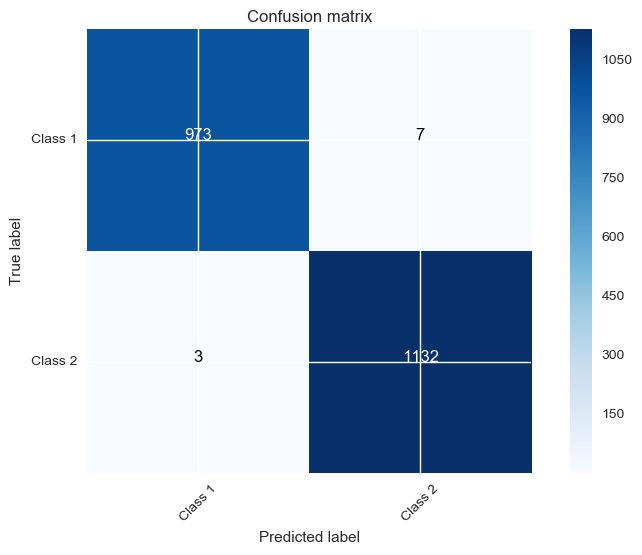

Accuracy score for 3|5
84.27970557308096
Confusion matrix
[[728 282]
 [ 17 875]]


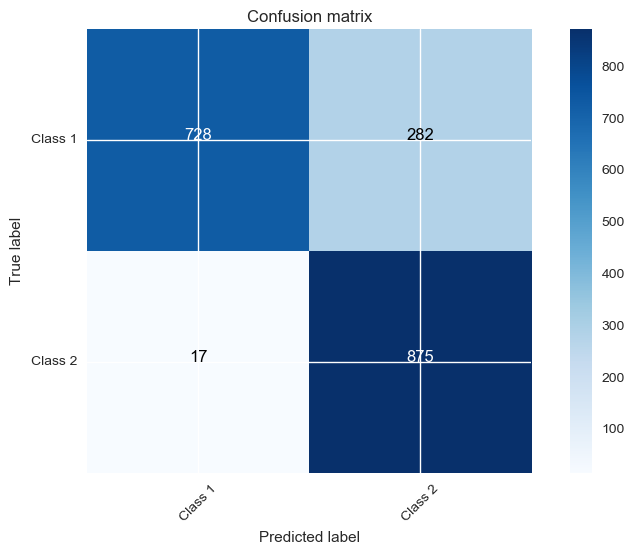

In [797]:
def main():
    
    print('Using MNIST dataset')
    filename = 'train.csv'
    trainingSet = loadCSV(filename)
    #select first two classes
    labels = [0,1]
    trainingSet = makeBinary(trainingSet, labels)
    #print(len(trainingSet))
    trainingSet = doStandardScaling(trainingSet)
    
    
    filename2 = 'test.csv'
    testSet = loadCSV(filename2)
    testSet = makeBinary(testSet, labels)
    testSet = doStandardScaling(testSet)
    
    
    # prepare model
    summaries = summarizeByClass(trainingSet)
    var = varianceFeatures(trainingSet)
    prior = calculatePrior(trainingSet, labels)
    weights = calculateWeights(summaries, var, labels)
    weight0 = calculateWeightZero(prior, summaries, var , labels)
    predictions = getPredictions(weight0, weights, testSet, labels)
    accuracy1 = getAccuracy(testSet, predictions)
    print('Accuracy score for 0|1')
    print(accuracy1)
    
    
    Y = np.asarray(testSet)
    Y = Y[:,:1]
    Y_test = Y.tolist()
    accuracy = confusion_matrix(Y_test,predictions)
    classes = ['Class 1', 'Class 2']
    plt.figure()
    plot_confusion_matrix(accuracy, classes=classes,title='Confusion matrix')
    plt.show()
    
    
    filename = 'train.csv'
    trainingSet = loadCSV(filename)
    #select first two classes
    labels = [3,5]
    trainingSet = makeBinary(trainingSet, labels)
    #print(len(trainingSet))
    trainingSet = doStandardScaling(trainingSet)
    
    
    filename2 = 'test.csv'
    testSet = loadCSV(filename2)
    testSet = makeBinary(testSet, labels)
    testSet = doStandardScaling(testSet)
    
    
    # prepare model
    summaries = summarizeByClass(trainingSet)
    var = varianceFeatures(trainingSet)
    prior = calculatePrior(trainingSet, labels)
    weights = calculateWeights(summaries, var, labels)
    weight0 = calculateWeightZero(prior, summaries, var , labels)
    predictions = getPredictions(weight0, weights, testSet, labels)
    accuracy1 = getAccuracy(testSet, predictions)
    print('Accuracy score for 3|5')
    print(accuracy1)
    
    
    Y = np.asarray(testSet)
    Y = Y[:,:1]
    Y_test = Y.tolist()
    accuracy = confusion_matrix(Y_test,predictions)
    classes = ['Class 1', 'Class 2']
    plt.figure()
    plot_confusion_matrix(accuracy, classes=classes,title='Confusion matrix')
    plt.show()
    
    
main()